<a href="https://colab.research.google.com/github/juanpablosalas/SalasJuanPablo_RECV_Entrega5/blob/main/SalasJuanPablo_RECV_Entrega5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#-- Descomprimimos el dataset
# !rm -r mnist
#!unzip "/content/drive/MyDrive/Colab Notebooks/mnist.zip"

In [ ]:
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.metrics import f1_score

In [ ]:
# Se importan los datos de MNIST
train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/0/3565.png'

In [ ]:
#Se aleatorizan los datos 
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [ ]:
#Datos de entrenamiento
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [ ]:
#Datos de validación
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [ ]:
#Datos de testeo
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

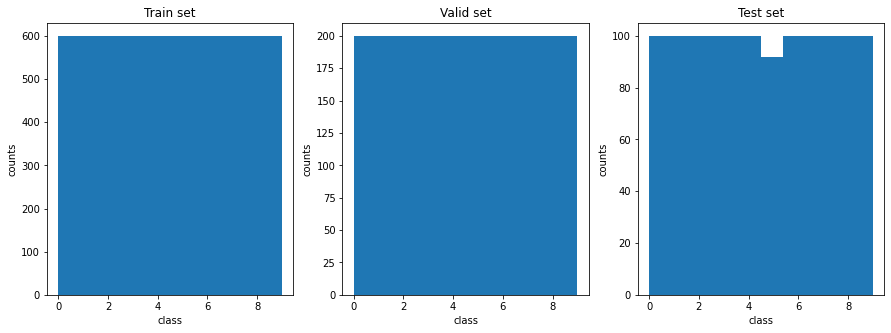

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

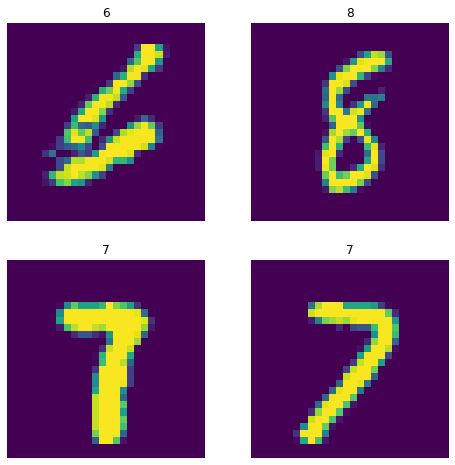

In [ ]:
#Visualización de datos
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [ ]:
#Transformación de arreglos a tensores
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [ ]:
#ANN de tres capas ocultas y 50 neuronas 
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def curvas_train_only(train_percentage):
  X_train_small = X_train[0:int(N_train*train_percentage/100)]
  Y_train_small = Y_train[0:int(N_train*train_percentage/100)]
  #-- Número de épocas
  n_epoch = 100
  
  #-- Listas de evaluación entrenamiento
  loss_train = []
  f1_train = []
  acc_train = []
  
  #-- Listas de evaluación validació
  loss_valid = []
  f1_valid = []
  acc_valid = []
  
  #-- Entrenamineto de la ANN
  for epoch in range(n_epoch):
    model.train()
    
    Xtr = X_train_small.view(X_train_small.size(0), -1)
    Y_pred = model(Xtr)
    
    loss = criterion(Y_pred,Y_train_small)
    loss_train.append(loss.item())
    
    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_small,Y_pred, average='macro') )
    
    acc = sum(Y_train_small == Y_pred)/len(Y_pred)
    acc_train.append(acc)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )
    
    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())
    
    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )
    
    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    #Curvas de loss, f1_score y accuracy
  fig = plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.plot(range(n_epoch), loss_train, label='train')
  plt.plot(range(n_epoch), loss_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,2)
  plt.plot(range(n_epoch), f1_train, label='train')
  plt.plot(range(n_epoch), f1_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('f1_score')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,3)
  plt.plot(range(n_epoch), acc_train, label='train')
  plt.plot(range(n_epoch), acc_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid()
  plt.savefig('./curves_ok_'+str(train_percentage)+'.png', bbox_inches='tight')
  plt.show()

  model.eval()
  
  Xts = X_test.view(X_test.size(0), -1)
  Y_pred = model(Xts)  
  loss = criterion(Y_pred,Y_test)
  
  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_test, Y_pred, average='macro')
  acc = sum(Y_test == Y_pred)/len(Y_pred)
  print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

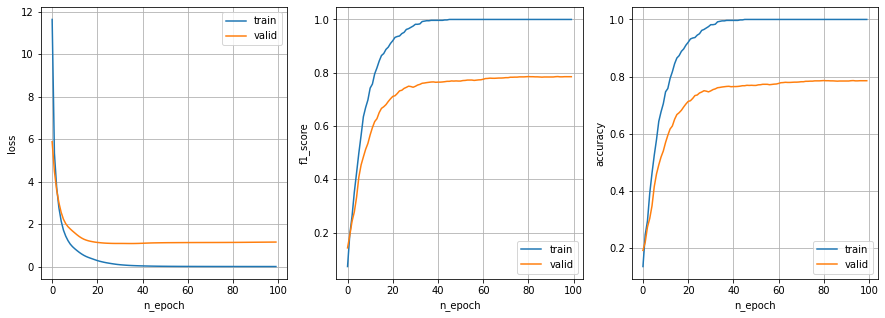

In [ ]:
curvas_train_only(10)

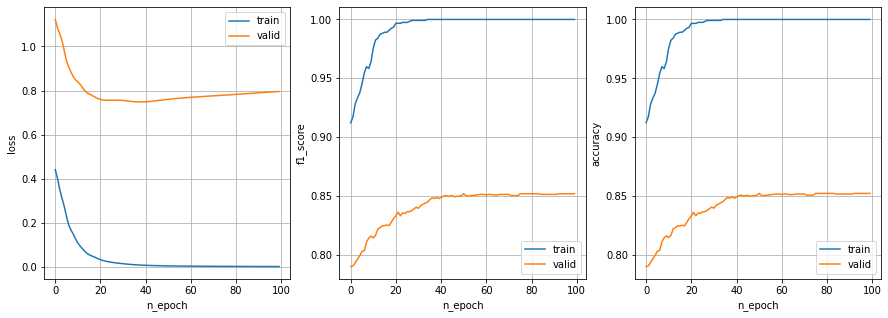

In [ ]:
curvas_train_only(20)

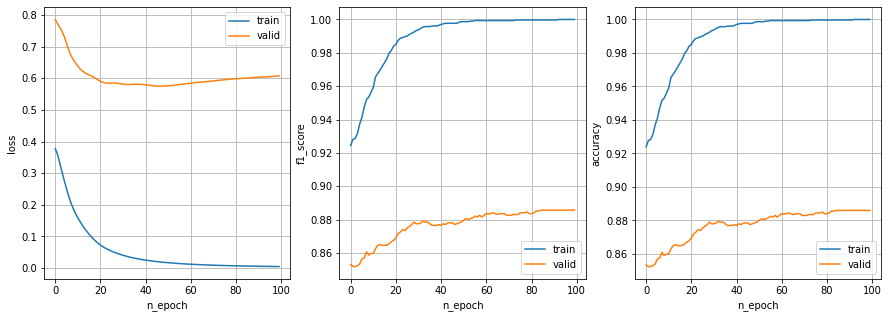

In [ ]:
curvas_train_only(50)

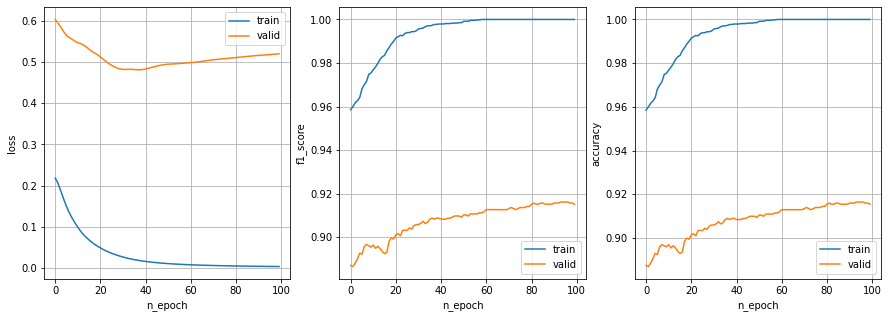

In [ ]:
curvas_train_only(80)

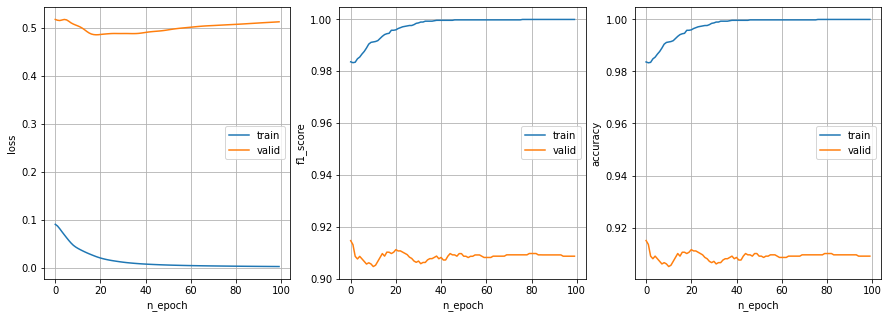

In [ ]:
curvas_train_only(100)

i) Indique cuál es la importancia del tamaño del conjunto de entrenamiento ii) Compare las curvas de entrenamiento y validación usando los 3 scores y iii) haga un breve análisis de los resultado obtenidos

In [ ]:
def curvas_test_only(test_percentage):
  X_test_small = X_test[0:int(N_test*test_percentage/100)]
  Y_test_small = X_test[0:int(N_test*test_percentage/100)]
  #-- Número de épocas
  n_epoch = 100
  
  #-- Listas de evaluación entrenamiento
  loss_train = []
  f1_train = []
  acc_train = []
  
  #-- Listas de evaluación validació
  loss_valid = []
  f1_valid = []
  acc_valid = []
  
  #-- Entrenamineto de la ANN
  for epoch in range(n_epoch):
    model.train()
    
    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)
    
    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())
    
    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )
    
    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())
    
    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )
    
    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    #Curvas de loss, f1_score y accuracy
  fig = plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.plot(range(n_epoch), loss_train, label='train')
  plt.plot(range(n_epoch), loss_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,2)
  plt.plot(range(n_epoch), f1_train, label='train')
  plt.plot(range(n_epoch), f1_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('f1_score')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,3)
  plt.plot(range(n_epoch), acc_train, label='train')
  plt.plot(range(n_epoch), acc_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid()
  plt.savefig('./curves_ok_'+str(train_percentage)+'.png', bbox_inches='tight')
  plt.show()

  model.eval()
  
  Xts = X_test_small.view(X_test_small.size(0), -1)
  Y_pred = model(Xts)  
  loss = criterion(Y_pred,Y_test_small)
  
  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_test_small, Y_pred, average='macro')
  acc = sum(Y_test_small == Y_pred)/len(Y_pred)
  print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))